# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

- <i>  <span style="color:#FFFF00; background:#00C000"> <b> Please download the notebook available as downloads in the next unit. </b> It will not run in the browser.</i>
- <i> <span style="color:#00C000"> RNN models are very heavy and it is possible that your code will take time to run. Be patient and try again if required. Keep your CPU free of other burdens during the time of run! </i>

### <span style="color:brown">Data Pre- Processing</span>

In this block of code, we have downloaded the data and scaled it, just as we did in the DNN model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import warnings 
warnings.simplefilter("ignore", UserWarning)

C:\Users\varun\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_csv('../data_modules/SBIN.csv', index_col=0,
                   parse_dates=True, na_values=0).dropna()

### <span style="color:brown"> Creating the input and target features

Now, we will create a feature data set called  <font color =red>X</font> which will be used to create the input for the RNN model.<br> 

Next, we create a dataset called <font color =red>y</font> which will contain the future close values.<br>

The model will train to predict the future close prices of these values.

In [3]:
X = data[['Open', 'High', 'Low', 'Close', 'Volume']]
y = data.Last.shift(-1)

In [4]:
# Divinding the data into train and test sets before scaling 
test_size = 60
X_train = X[:-test_size]
X_test = X[-test_size:]

y_train = y[:-test_size]
y_test = y[-test_size:]

In [5]:
# Scaling the X_train and X_test datasets
max_ = X_train[['Open', 'High', 'Low', 'Close']].max().max()
min_ = X_train[['Open', 'High', 'Low', 'Close']].min().min()

scl = MinMaxScaler()

# Scaling X_train

X1 = (X_train[['Open', 'High', 'Low', 'Close']]-min_)/(max_-min_)
X2 = scl.fit_transform(X_train[['Volume']].values.reshape(-1, 1))
X1 = np.array(X1)

X_train= X_train.assign(Open=X1[:, 0])
X_train= X_train.assign(High=X1[:, 1])
X_train= X_train.assign(Low=X1[:, 2])
X_train= X_train.assign(Close=X1[:, 3])
X_train= X_train.assign(Volume=X2[:, 0])


#Scaling X_test

X1 = (X_test[['Open', 'High', 'Low', 'Close']]-min_)/(max_-min_)
X2 = scl.transform(X_test[['Volume']].values.reshape(-1, 1))
X1 = np.array(X1)

X_test= X_test.assign(Open=X1[:, 0])
X_test= X_test.assign(High=X1[:, 1])
X_test= X_test.assign(Low=X1[:, 2])
X_test= X_test.assign(Close=X1[:, 3])
X_test= X_test.assign(Volume=X2[:, 0])

# Creating scaled X i.e. X_scaled
X_scaled = pd.concat([X_train,X_test], axis=0)
X_scaled


,Open,High,Low,Close,Volume
Date,,,,,
2015-01-01 00:00:00+00:00,0.808668,0.821226,0.800049,0.816301,0.015643
2015-01-02 00:00:00+00:00,0.818025,0.837478,0.818025,0.822458,0.030211
2015-01-05 00:00:00+00:00,0.827382,0.830091,0.806944,0.810145,0.027147
2015-01-06 00:00:00+00:00,0.796602,0.802019,0.740951,0.746860,0.050909
2015-01-07 00:00:00+00:00,0.747353,0.759911,0.723467,0.748092,0.049825
...,...,...,...,...,...
2018-12-21 00:00:00+00:00,0.716080,0.730116,0.702044,0.707461,0.052628
2018-12-24 00:00:00+00:00,0.715341,0.722728,0.698843,0.713125,0.038322
2018-12-26 00:00:00+00:00,0.712140,0.722728,0.684068,0.718542,0.040760


In this example, I have taken a timestep of 20 days to create the input data. By doing this, we will feed the past 20-days of data at every time step to the RNN. We can change the target data to predict the next 5 days, by changing the code to contain y_list.append(y.iloc[i:i+5]), then you can predict a sequence of 5 days data.

In [6]:
timestep = 20
X_list = []
y_list = []
for i in range(timestep, len(X_scaled)):
    X_list.append(np.array(X_scaled.iloc[i-timestep:i]))
    y_list.append(y.iloc[i])

In [7]:
X_train = np.array(X_list)[:-test_size]
y_train = np.array(y_list)[:-test_size]
X_test = np.array(X_list)[-test_size:]
y_test = np.array(y_list)[-test_size:]

In [8]:
X_train.shape

(906, 20, 5)

As, you can see the X_train dataset contains data with OHLCV (5 columns) data, with each of them containing the past 20 days of this data.

### <span style="color:brown"> Creating an RNN model

First, we import the necessary modules for the model from the keras library.

In [9]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint

In this model, I have added a dropout layer with a 50% drop ratio. That means that half of the neurons in the layer preceding it will be switched off while training. If you choose a model that is is not very deep then the chances of overfitting are very less and you may not need a dropout layer.

In [10]:
dropout_ratio = 0.5

Let us begin to build the model, as you might recall the first layer will always be a sequential one. Followed by an RNN in this case, as we want to test a simple RNN model to check the accuracy.

After this, I have added a few Dense layers (fully connected Neural Network) along with the dropout layers.

As the depth of the model increases, the model's ability to create complex features also increases. But, this often results in overfitting.

In [11]:
model = Sequential()
model.add(SimpleRNN(timestep, input_shape=(
    X_train.shape[1], X_train.shape[2])))
model.add(Dense(32))
model.add(Dropout(dropout_ratio))
model.add(Dense(64))
model.add(Dropout(dropout_ratio))
model.add(Dense(128))
model.add(Dropout(dropout_ratio))
model.add(Dense(256))
model.add(Dropout(dropout_ratio))
model.add(Dense(512))
model.add(Dropout(dropout_ratio))
model.add(Dense(1024))
model.add(Dropout(dropout_ratio))
model.add(Dense(2048))
model.add(Dropout(dropout_ratio))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

### <span style="color:brown"> Saving and loading the model

I have specified the file path as RNN-weights-best.hdf5 to save the weights of the model.

The verbose=1 parameter defines how much information about every batch training needs to be printed.

#### We strongly encourage you to change all the parameters discussed above to create your own models and test them out.


In [12]:
filepath = 'RNN-weights-best.hdf5'
checkpoint = ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

Now let us visualize our model.

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20)                520       
                                                                 
 dense (Dense)               (None, 32)                672       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

Now, it's time to train the model.

While training the model we have to specify the size of the batch, this indicates to the model how many train samples it should take in a single batch while training.

The validation split randomly splits the train data to verify the performance of the model on untrained data.

Epochs are the number of runs the model needs to make for the convergence of train and validation losses.

In [14]:
model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=1,
          validation_split=0.2, callbacks=[checkpoint])

Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 30987.7188
Epoch 00001: val_loss improved from inf to 5575.39111, saving model to RNN-weights-best.hdf5
15/15 [==============================] - 3s 96ms/step - loss: 30987.7188 - val_loss: 5575.3911
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 11777.9756
Epoch 00002: val_loss improved from 5575.39111 to 304.43411, saving model to RNN-weights-best.hdf5
15/15 [==============================] - 1s 48ms/step - loss: 11777.9756 - val_loss: 304.4341
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 9984.5039 
Epoch 00003: val_loss did not improve from 304.43411
15/15 [==============================] - 1s 64ms/step - loss: 9984.5039 - val_loss: 1254.2665
Epoch 4/100
15/15 [==============================] - ETA: 0s - loss: 8609.8760
Epoch 00004: val_loss did not improve from 304.43411
15/15 [==============================] - 1s 65ms/step - loss: 8609.8760 - val_loss: 1807.6110
Epoch 

Epoch 36/100
15/15 [==============================] - ETA: 0s - loss: 764.1835
Epoch 00036: val_loss did not improve from 99.34421
15/15 [==============================] - 0s 33ms/step - loss: 764.1835 - val_loss: 183.2125
Epoch 37/100
15/15 [==============================] - ETA: 0s - loss: 806.8894
Epoch 00037: val_loss improved from 99.34421 to 94.39890, saving model to RNN-weights-best.hdf5
15/15 [==============================] - 1s 45ms/step - loss: 806.8894 - val_loss: 94.3989
Epoch 38/100
15/15 [==============================] - ETA: 0s - loss: 717.4424
Epoch 00038: val_loss did not improve from 94.39890
15/15 [==============================] - 1s 34ms/step - loss: 717.4424 - val_loss: 105.4799
Epoch 39/100
15/15 [==============================] - ETA: 0s - loss: 812.1299
Epoch 00039: val_loss did not improve from 94.39890
15/15 [==============================] - 1s 40ms/step - loss: 812.1299 - val_loss: 115.3290
Epoch 40/100
15/15 [==============================] - ETA: 0s - l

Epoch 72/100
15/15 [==============================] - ETA: 0s - loss: 614.9459
Epoch 00072: val_loss did not improve from 68.83870
15/15 [==============================] - 1s 36ms/step - loss: 614.9459 - val_loss: 101.2225
Epoch 73/100
15/15 [==============================] - ETA: 0s - loss: 609.7711
Epoch 00073: val_loss did not improve from 68.83870
15/15 [==============================] - 1s 40ms/step - loss: 609.7711 - val_loss: 157.8616
Epoch 74/100
15/15 [==============================] - ETA: 0s - loss: 619.3524
Epoch 00074: val_loss did not improve from 68.83870
15/15 [==============================] - 0s 32ms/step - loss: 619.3524 - val_loss: 159.4989
Epoch 75/100
15/15 [==============================] - ETA: 0s - loss: 582.6038
Epoch 00075: val_loss improved from 68.83870 to 67.54323, saving model to RNN-weights-best.hdf5
15/15 [==============================] - 1s 38ms/step - loss: 582.6038 - val_loss: 67.5432
Epoch 76/100
13/15 [=========================>....] - ETA: 0s - l

Once we have generated the best weights and saved them using the callback feature, we would want our final model to have these best weights fitted before making the predictions on the test data. So, we load these weights using the load_weights function.

In [15]:
model.load_weights("RNN-weights-best.hdf5")

### <span style="color:brown"> Predicting the Close Prices

Now, we will create a list that would hold the RNN model's predictions on the test data.

After this, we create a dataframe called performance that contains the actual close values and the predicted close values to analyze the predictions.

We reshape the predictions to a single column vector to match the shape of the actual y_test column vector. We need to do this, to pass these two vectors as inputs to the dataframe called performance.

In [16]:
predict_close = []
predict_close = np.reshape(model.predict(X_test), (1, -1))

In [17]:
predict_close = predict_close[0]

In [18]:
performance = pd.DataFrame([predict_close, y_test])

In [19]:
# Since the two vectors are added as rows, we take the transpose of the dataframe to create the appropriate columns.
performance = performance.T

In [20]:
performance.columns = ['Predicted', 'Actual']
Spread = performance.Actual-performance.Predicted
performance.head()

,Predicted,Actual
0,268.856018,271.70
1,271.076294,271.35
2,275.283661,258.35
3,269.249542,265.75
4,262.327148,262.95


### <span style="color:brown"> Visualizing and comparing the performance

Now, let us plot the predicted and actual values of the close prices.

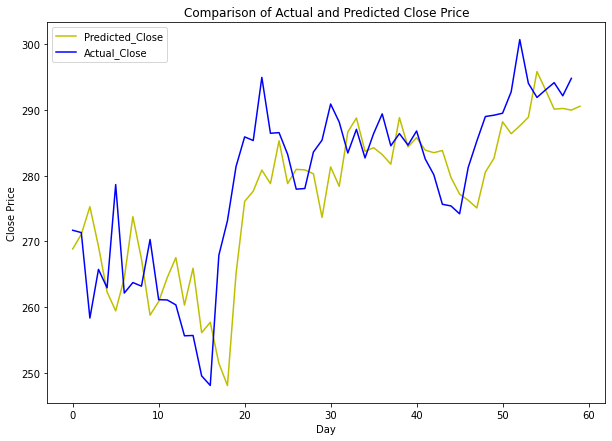

In [21]:
plt.figure(figsize=(10, 7))
plt.title("Comparison of Actual and Predicted Close Price")
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.plot(predict_close, c='y')
plt.plot(y_test.tolist(), c='b')
plt.legend(['Predicted_Close', 'Actual_Close'])
plt.show()

### <span style="color:brown"> Conclusion

As you can see the model makes a prediction that looks lagging in nature. To make the algorithm more accurate we will have to optimize the various hyperparameters used in the model. 

We will look at how to tune these hyperparameters using GridSearch in the next section.